In [58]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
import scipy.io as sio
import os, pandas
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from scipy.special import expit
import pickle 
from scipy.stats import spearmanr
from scipy.stats import wilcoxon
from IPython.display import Markdown as md
from scipy import stats
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
n_iterations = 50

In [3]:
np.random.seed(n_iterations)
random_seed = np.random.randint(100)

In [4]:
evaluation_experiments = ['central_biased_morphs', '10pct_spaced_morphs', 'masked_morphs', 'crossed_morphs']

In [5]:
reliability_experiments = [i for i in evaluation_experiments if i != 'crossed_morphs']

In [89]:
def show_model_parameters(m_, idx_ =-1, markdown=False):
    
    # fit model 
    m_ = m_.fit() 
    # extract significant figures from float 
    def sigfigs(x):
        if x>0: 
            d = int(str('%.2e'%x)[('%.2e'%x).find('-')+1:])
            n = np.round(float(str('%.02e'%x)[0:3]))
            return n, d
        else: 
            return x, x
    
    # extract model parameters 
    beta, pval, df_model = m_.params[idx_], m_.pvalues[idx_], m_.df_model
    rsqrd, df_resid, tvalues = m_.rsquared, m_.df_resid, m_.tvalues[idx_]
    
    sigfigs(pval)
    # show exact p values up to three significant figures 
    if sigfigs(pval)[1] < 4:
        stat_str = "$R^{2} = %.02f$ $\\beta = %.2f$, $F(%d, %d)$ = $%.02f, P = %.03f $"
        report = stat_str%(rsqrd, beta, df_model, df_resid, tvalues, pval, )
    else:
        stat_str = "$R^{2} = %.02f$ $\\beta = %.2f$, $F(%d, %d)$ = $%.02f, P = %.0f $ x $ 10 ^{-%d} $"
        report = stat_str%(rsqrd, beta, df_model, df_resid, tvalues, sigfigs(pval)[0], sigfigs(pval)[1])
    
    if markdown: 
        REPORT = md(report)
    else: 
        REPORT = report 
    # return markdown visualization 
    return  REPORT


In [6]:
def get_masked_indices(): 
    f = open("imageFiles_1100-1.txt", "r")
    mask_morphs_indices = [i[1:-2] for i in f.read().splitlines()]
    f.close() 
    return mask_morphs_indices

In [9]:
def extract_behavioral_data(): 
    """
    example data format--converted from .mat files: 
        > experiment_data = behavioral_data[ list(behavioral_data)[2]   ]
        > experiment_data.shape
        (440, 18, 8, 9)
        
    where
    - 440 = unique stimuli
    - 18 = data containing array where 
    ---- indices 4-14 morph level coded as 1-hot vector 
    ----      i.e. [0 1 0 0 0 0 0 0 0 0 0] =  10% dog morph 
    ----      i.e. [0 0 0 0 0 0 0 0 0 0 1] = 100% dog morph 
    - 8 = sessions/days
    - 9 = monkeys    
    """
    # 
    data_path = 'single_trial_data_2021.1.16/'
    # import names of files
    data_files = [i for i in os.listdir(data_path) if 'DS' not in i]
    # all imported files 
    behavioral_data = {i[:-4]: sio.loadmat(os.path.join(data_path,i))['raw_data'] for i in data_files}
    # formatting :/ 
    stimuli_path = 'eLife_stim/'
    stim_folders = [i for i in os.listdir(stimuli_path) if 'Exp' in i]
    stim_files = {i: [i for i in os.listdir(os.path.join(stimuli_path, i)) if 'DS' not in i] for i in stim_folders}
    stim_files = {i: np.sort(stim_files[i]) for i in stim_files}
    mask_morph_indices = get_masked_indices()     
    
    naming = {'Exp2_central_bias': 'central_biased_morphs', 
              'Exp4_crossed_morphs': 'crossed_morphs', 
              'Exp1_linear_distribution': '10pct_spaced_morphs',
              'Exp3_masked_morphs': 'masked_morphs', 
              'central_biased_morphs': 'Exp2_central_bias',
              'crossed_morphs':'Exp4_crossed_morphs', 
              '10pct_spaced_morphs':'Exp1_linear_distribution',
              'masked_morphs':'Exp3_masked_morphs'}
    
    stim_files = {naming[i]: stim_files[i] for i in stim_files}
    
    percent_map = {
         '10pct_spaced_morphs': array([0,10,20,30,40,50,60,70,80,90,100]),
         'central_biased_morphs': array([0,25,35,40,45,50,55,60,65,75,100]),
         'masked_morphs': array([0,25,  35,  40,  45,  50,  55,  60,  65,  75, 100]),
         'crossed_morphs': array([0,10,20,30,40,50,60,70,80,90,100])}
    
    lesion_map = {0:'CON', 1:'CON', 2:'CON', 3:'TE', 4:'TE', 5:'TE', 6:'PRC', 7:'PRC', 8:'PRC'}
    
    name_map = {0:0,1:1,2:2,3:6,4:7,5:8,6:3,7:4,8:5}
    
    # initialize dataframe 
    df = pandas.DataFrame() 
    
    for e in evaluation_experiments:

        experiment = behavioral_data[ e ]

        for subject in range(experiment.shape[3]): 
        
            for day in range(experiment.shape[2]): 

                # extract all experimental data for this day
                day_data = experiment[:,:,day, subject]
                # only keep trials where there is RT data (i.e. there's a responses)--marked as 0 otherwise
                day_data = day_data[ day_data[:,1] > 0, :]

                if 'masked_morphs' in e: 
                    ids = [int(i-1) for i in day_data[:, 5]] # FIXED? 
                    image_name = [mask_morph_indices[i] for i in ids]
                    mask_FROM_IMAGE = [i[-6:-4] for i in image_name] 
                    percent = [percent_map[e][int(i-1)] for i in day_data[:, 4]] 
                    mask_FROM_MAT = day_data[:, 3]  
                    response = day_data[:, 6]
                    correct = (np.array(percent) > 50) * (response) 
                    PERCENT_FROM_IMAGE = [int(i[11:14]) for i in image_name]
                    ground_truth = (np.array(percent) >= 50)
                    
                else: 
                    # all indices from personal correspondence
                    ids = [int(i-1) for i in day_data[:, -1]]
                    response = day_data[:,14]
                    # extract all columns that have information related to the percent morph level
                    percent_indices = np.array([day_data[i,3:14] for i in range(day_data.shape[0])])
                    percent = np.array([percent_map[e][int(i)] for i in percent_indices.argmax(1) ])
                    image_name = [stim_files[e][i] for i in ids]
                    PERCENT_FROM_IMAGE = [int(i[11:14]) for i in image_name]
                    ground_truth = (np.array(percent) >= 50)
                    #ground_truth[percent==50] = np.random.randint(0,2, sum(percent==50))
 
                tiny_df = pandas.DataFrame({
                    'group': np.repeat(lesion_map[subject], day_data.shape[0]),
                    'subject': np.repeat(name_map[subject], day_data.shape[0]), 
                    'experiment': np.repeat(e, day_data.shape[0]),
                    'day': np.repeat(day, day_data.shape[0]), 
                    'trial': range(day_data.shape[0]), 
                    'percent': percent, 
                    'percent_CHECK': PERCENT_FROM_IMAGE, 
                    'image_id': ids, 
                    'image': image_name, 
                    'ground_truth': ground_truth,
                    'choice': response,    
                    'correct': ground_truth == response
                    })

                df = df.append(tiny_df, ignore_index=True)
            
    # remove all trials where images (via the stimulus ID)
    df = df[df.percent==df.percent_CHECK]
    df = df[df.group!='TE']
    
    return df[[i for i in df.columns if 'CHECK' not in i]]

In [10]:
df = extract_behavioral_data()

In [11]:
def within_subject_splithalf_reliability(n_iterations=50): 
    
    np.random.seed(random_seed)

    def split_means(v): 
        v = np.random.permutation(v)
        return v[:len(v)//2].mean(), v[len(v)//2:].mean()

    reliability = pandas.DataFrame()

    for subject in df.subject.unique(): 

        subject_df = df[df.subject==subject]

        for e in reliability_experiments: 

            i_df = subject_df[subject_df.experiment==e]

            for i_iteration in range(n_iterations): 

                splits = [split_means(i_df[i_df.image==i].choice.values) for i in sort(i_df.image.unique())]
                both_splits = np.array(splits).T.flatten() 
                percent = [i_df[i_df.image_id==i].percent.values[0:2] for i in sort(i_df.image_id.unique())]
                splits_correct = [split_means(i_df[i_df.image==i].correct.values) for i in sort(i_df.image.unique())]
                both_correct = np.array(splits).T.flatten()

                iteration_df = pandas.DataFrame(
                    {'group': [i_df.group.values[0] for i in range(len(both_splits))],
                     'subject':  np.repeat(subject, len(both_splits)),
                     'experiment': np.repeat(e, len(both_splits)),
                     'percent': np.array(percent).T.flatten(),
                     'image': np.array([(i, i) for i in sort(i_df.image.unique())]).T.flatten() , 
                     'iteration': np.repeat(i_iteration, len(both_splits)),
                     'split':np.array([(1, 2) for i in range(len(splits))]).T.flatten() ,
                     'choice':both_splits, 
                     'correct': both_correct, 
                     'split_r': np.corrcoef(np.array(splits)[:,1], np.array(splits)[:,0])[0,1], 
                     'split_r2': r2_score(np.array(splits)[:,1], np.array(splits)[:,0]), 
                    })

                reliability = reliability.append(iteration_df, ignore_index=True)

    return reliability

In [12]:
load_reliability = True

In [13]:
if load_reliability: 
    df_reliability = pandas.read_csv('within-subject_reliability_%d_iterations.csv'%n_iterations)
else: 
    df_reliability  = within_subject_splithalf_reliability(n_iterations=n_iterations)
    df_reliability.to_csv('within-subject_reliability_%d_iterations.csv'%n_iterations)

In [15]:
def get_reliability_matrix(rdf, resolution='subject', target='image', measure='r'): 
    
    elements = list(np.sort(rdf[resolution].unique()))
    n_elements = len(elements) 
    noise = {}
    experiment_matrices = {'target': target,'resolution':resolution} 
    
    for e in rdf.experiment.unique(): 
        
        matrix_rsq = np.zeros([n_elements,n_elements])
        matrix_pdf = np.zeros([n_elements,n_elements])
        noise[e] = {} 
        
        e_df = rdf[rdf.experiment == e]

        for s in e_df[resolution].unique(): 
            
            noise[e][s] = {} 
            s_df = e_df[e_df[resolution]==s]
            
            for q in e_df[resolution].unique(): 

                q_df = e_df[e_df[resolution]==q]
                
                if s == q: 
                    # DIAGONAL
                    if target == 'image': 
                        svec = s_df[s_df.split==1].choice.values
                        qvec = q_df[q_df.split==2].choice.values
                    elif target == 'percent': 
                        svec = s_df[s_df.split==1].groupby(['percent', 'iteration']).mean().choice.values
                        qvec = q_df[q_df.split==2].groupby(['percent', 'iteration']).mean().choice.values
                
                else: 
                    # OFF DIAGONAL
                    if target == 'image': 
                        svec = s_df.choice.values
                        qvec = q_df.choice.values
                    elif target == 'percent': 
                        svec = s_df.groupby(['percent', 'iteration']).mean().choice.values
                        qvec = q_df.groupby(['percent', 'iteration']).mean().choice.values
                
                # GET DISTRIBUTION TO ESTIMATE NOISE CEILING 
                smat = svec.reshape((svec.shape // (s_df.iteration.max()+1))[0], -1)
                qmat = qvec.reshape((qvec.shape // (s_df.iteration.max()+1))[0], -1)
                
                if measure == 'r': 
                    mu_r = np.corrcoef(svec, qvec)[0,1]    
                    pdf = [np.corrcoef(smat[:, i], qmat[:, i])[0, 1] for i in range(smat.shape[1])] 
                else: 
                    mu_r = r2_score(svec, qvec)
                    pdf = [r2_score(smat[:, i], qmat[:, i]) for i in range(smat.shape[1])] 
                
                matrix_rsq[elements.index(s),elements.index(q)] = mu_r
                noise[e][s,q] = pdf
            
        experiment_matrices[e] = matrix_rsq   
        
    experiment_matrices['noise'] = noise
    
    return experiment_matrices

In [16]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def show_values(grid, ax, th=.8): 
    for (j,i),label in np.ndenumerate(grid):
        #if j<=i: 
        ax.text(i, 
                j, 
                np.round(label,2) ,
                ha='center',
                va='center', 
                size=9, 
                #fontweight='bold',
                color=['black','white'][1*(label<th)])
    imin = -.5
    imax = .5+j
    
    plt.xticks(np.arange(0,j+1), np.arange(0,j+1))
    plt.yticks(np.arange(0, j+1,), np.arange(0,j+1))
    plt.ylim(imax, imin)
    plt.xlim(imin, imax)
    
    i_color = 'white'
    i_width=2

    if j<4:
        plt.xlabel('GROUP')
    else: 
        plt.xlabel("SUBJECT")

In [17]:
def load_representations(): 

    with open('model_responses.pkl', 'rb') as f:
        representations = pickle.load(f)
                
    return representations#, image_labels, 

In [18]:
naming = {'Exp2_central_bias': 'central_biased_morphs', 
          'Exp4_crossed_morphs': 'crossed_morphs', 
          'Exp1_linear_distribution': '10pct_spaced_morphs',
          'Exp3_masked_morphs': 'masked_morphs', 
          'central_biased_morphs': 'Exp2_central_bias',
          'crossed_morphs':'Exp4_crossed_morphs', 
          '10pct_spaced_morphs':'Exp1_linear_distribution',
          'masked_morphs':'Exp3_masked_morphs'}

In [19]:
def bound(vector, MIN=0, MAX=100, SCALE=100): 
    return np.array([max(min(i*SCALE, MAX), MIN) for i in vector])

In [20]:
def build_model1(df, n_iterations): 
    
    def make_column(x, test_df): return np.repeat(x, len(test_df))
            
    np.random.seed(random_seed)
    readouts = {'linear': LinearRegression(), 
                'logistic': LogisticRegression(solver='lbfgs', max_iter=2000)}

    train_test_ratio = 4/5
    analysis_level = 'image'
    target = 'ground_truth'
    model_type = 'logistic'

    df_model = pandas.DataFrame()

    for i_test in evaluation_experiments:

        exp_df = df[df.experiment==i_test]
        
        # model representations
        if i_test == 'masked_morphs': 
            mask_indices = get_masked_indices()             
            X = [representations[naming[i_test]][i] for i in mask_indices]
        else: 
            X = [representations[naming[i_test]][i] for i in representations[naming[i_test]].keys() ]
    
        for i_iteration in range(n_iterations):

            random_order = np.random.permutation(range(len(X)))
            i_split = int(len(random_order)*(train_test_ratio))

            train = exp_df[ [i in random_order[:i_split] for i in exp_df.image_id.values] ] 
            test  = exp_df[ [i in random_order[i_split:] for i in exp_df.image_id.values] ] 

            train = train.groupby(analysis_level, as_index=False).mean()
            test  = test.groupby(analysis_level, as_index=False).mean()

            x_train = [X[int(i-1)] for i in train.image_id.values]
            x_test  = [X[int(i-1)] for i in test.image_id.values]
            
            readouts[model_type].fit(x_train, train[target].values)
            model_predictions =  readouts[model_type].predict(x_test)

            # bookkeeping
            i_df = pandas.DataFrame({
                        'group': make_column('model', test), 
                        'experiment': make_column(i_test, test),
                        'iteration': make_column(i_iteration, test), 
                        'percent': test.percent.values, 
                        'image_id': test.image_id.values, 
                        'image': test.image.values, 
                        'ground_truth': 1 * (test.percent.values >= 50),
                        'analysis_level': make_column(analysis_level, test), 
                        'target': make_column(target, test), 
                        'choice': model_predictions, 
                        'correct': np.array(model_predictions) == (1 * (test.percent.values >= 50)), 
                        'y': test[target].values
                        })

            df_model = df_model.append(i_df, ignore_index=True)
    
    return df_model

In [21]:
def build_model2(df, n_iterations): 

    def make_column(x, test_df): return np.repeat(x, len(test_df))
                
    np.random.seed(random_seed)
    readouts = {'linear': LinearRegression(), 
                'logistic': LogisticRegression(solver='lbfgs', max_iter=2000)}
    
    train_test_ratio = 4/5
    analysis_level = 'image'
    target = 'choice'
    model_type = 'linear'
    mask_indices = get_masked_indices()   
    df_model = pandas.DataFrame()

    for i_test in df.experiment.unique():
        
        e_df = df[df.experiment==i_test]

        # model representations
        if i_test == 'masked_morphs': 
            X = [representations[naming[i_test]][i] for i in mask_indices]
        else: 
            X = [representations[naming[i_test]][i] for i in representations[naming[i_test]].keys() ]

        for i_iteration in range(n_iterations):

            random_order = np.random.permutation(range(len(X)))
            i_split = int(len(random_order)*(train_test_ratio))

            for i_subject in df.subject.unique(): 

                s_df = e_df[e_df.subject==i_subject]

                train = s_df[ [i in random_order[:i_split] for i in s_df.image_id.values] ] 
                test  = s_df[ [i in random_order[i_split:] for i in s_df.image_id.values] ] 

                train = train.groupby(analysis_level, as_index=False).mean()
                test  = test.groupby(analysis_level, as_index=False).mean()

                x_train = [X[int(i-1)] for i in train.image_id.values]
                x_test  = [X[int(i-1)] for i in test.image_id.values]

                readouts[model_type].fit(x_train, train[target].values)
                model_predictions =  readouts[model_type].predict(x_test)

                # bookkeeping
                i_df = pandas.DataFrame({
                            'group': make_column('model', test), 
                            'subject': make_column(i_subject, test), 
                            'experiment': make_column(i_test, test),
                            'iteration': make_column(i_iteration, test), 
                            'percent': test.percent.values, 
                            'image_id': test.image_id.values, 
                            'image': test.image.values, 
                            'ground_truth': 1 * (test.percent.values >= 50),
                            'analysis_level': make_column(analysis_level, test), 
                            'target': make_column(target, test), 
                            'choice': model_predictions, 
                            'correct': (np.array(model_predictions)>=.5) == (1*(test.percent.values >= 50)), 
                            'y': test[target].values
                            })

                df_model = df_model.append(i_df, ignore_index=True)

    return df_model

In [23]:
representations = load_representations() 

In [24]:
df_m1 = build_model1(df, n_iterations)

In [25]:
df_m2 = build_model2(df, n_iterations)

In [26]:
colorscheme = {'CON':'#441580',
               'CON':'#7123d4',
               'PRC':'#01b282', 
               'model':'black'}

In [27]:
def show_experimental_performance(df, df_m): 

    LR = LogisticRegression(solver='lbfgs')
    iplot=1
    
    def colorFader(c1,c2,mix=0): 
        # https://stackoverflow.com/questions/25668828/how-to-create-colour-gradient-in-python
        c1=np.array(mpl.colors.to_rgb(c1))
        c2=np.array(mpl.colors.to_rgb(c2))
        return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

    lcolors = {'PRC': colorscheme['PRC'], 
               'CON': colorscheme['CON'], 
               'model':'black'}
    
    lesion_groups = ['CON', 'PRC']
    naming = {'CON':'PRC Intact', "PRC":'PRC Lesion', }
    
    ################################# SUBJECT
    
    for e in df.experiment.unique():

        for i_group in lesion_groups: 
            
            ax = plt.subplot(len(df.experiment.unique()), len(lesion_groups)+2, iplot)
            
            if iplot in [1, 5, 9, 13]: 
                plt.ylabel('Proportion Identified as Dog')
                plt.text(-.1, 1.05, ['a', 'b', 'c', 'd'][(iplot-1)//4], fontsize=12,
                         fontweight='bold', transform=ax.transAxes,)
                

            
            group_data = df[(df.group==i_group)*(df.experiment==e)]
            n_days = len(group_data.day.unique())

            for i_day in range(n_days):         

                i_color = colorFader('black',colorscheme[i_group],i_day/n_days)
                day_data = group_data[group_data.day==i_day]
                clf = LR.fit(np.expand_dims(day_data.percent,1), day_data.choice)
                X_lims = np.linspace(0, 100, 100).round(0)
                loss = expit(X_lims * clf.coef_ + clf.intercept_).ravel()
                plt.plot(X_lims, loss, linewidth=1, 
                         color=i_color)

                i_behavior = day_data.groupby(['percent'], as_index=False).mean() 
                plt.scatter(x=i_behavior.percent, y=i_behavior.choice, 
                            facecolor='', s=10, linewidth=.5, edgecolor=i_color)

                plt.scatter([], [], color=i_color, label='Repeat %d'%i_day)
            
            if e == df.experiment.unique()[-1]: 
                plt.xlabel('Morph Level (% Dog)', labelpad=10)
            elif e == df.experiment.unique()[0]: 
                plt.title('%s Group Behavior'%naming[i_group], y=1.05)
                
            plt.legend(loc=4, framealpha=0, fontsize=9, title_fontsize=9, 
                       title='Experiment %d'%(((iplot-1)//4)+1))
            iplot+=1
            plt.ylim(-.05, 1.05)
        
        ####################################### MODEL PERFORMANCE ACROSS %s
        ax = plt.subplot(len(df.experiment.unique()), len(lesion_groups)+2, iplot)
                
        for i_iteration in df_m.iteration.unique(): 
            i_df = df_m[(df_m.iteration==i_iteration)&(df_m.experiment==e)]
            iteration_data = i_df.groupby(['percent'], as_index=False).mean()
            try: 
                clf = LR.fit(np.expand_dims(i_df.percent.values,1), i_df.choice.values)
            except: 
                choice_values = i_df.choice.values >= .5 
                clf = LR.fit(np.expand_dims(i_df.percent.values,1), choice_values)
            X_lims = np.linspace(0, 100, 100).round(0)
            loss = expit(X_lims * clf.coef_ + clf.intercept_).ravel()
            plt.plot(X_lims, loss, color=colorscheme['model'], linewidth=2, alpha=.1)
        
        plt.plot([], [], color=colorscheme['model'], linewidth=2, alpha=.3, label='Single')
        
        try: 
            clf = LR.fit(np.expand_dims(df_m.percent.values,1), df_m.choice.values)
        except: 
            print('!')
            choice_values = df_m.choice.values >= .5 
            clf = LR.fit(np.expand_dims(df_m.percent.values,1), choice_values)
        
        X_lims = np.linspace(0, 100, 100).round(0)
        loss = expit(X_lims * clf.coef_ + clf.intercept_).ravel()
        plt.plot(X_lims, loss, color=colorscheme['model'], linewidth=1, alpha=1, label='Average')
        plt.legend(loc=4, framealpha=0, fontsize=9, title='Experiment %d\n     Iteration'%(((iplot-1)//4)+1),
                   title_fontsize=9)
        
        if iplot ==3: 
            #plt.text(-.1, 1.05, 'c', fontsize=12, fontweight='bold', transform=ax.transAxes,)
            plt.title('VVS Model Behavior', y=1.05)
        iplot+=1
        
        
        if e == df.experiment.unique()[-1]: 
            plt.xlabel('Morph Level (% Dog)', labelpad=10)
        
        res = 'group'
        target = 'percent'
        alpha=1
        s = 40
        #################################### MODEL FIT TO GROUP BEHAVIOR 
        for group in ['CON', "PRC"]: 
            
            ax = plt.subplot(len(df.experiment.unique()), len(lesion_groups)+2, iplot)
            
            igroup = df[(df[res]==group)&(df.experiment==e)]
            imodel = df_m[df_m.experiment==e].groupby(target, as_index=False)
            igroup = igroup.groupby(target, as_index=False)

            plt.scatter(x=imodel.mean().choice.values, 
                        y=igroup.mean().choice, 
                        facecolor=colorscheme[group],
                        edgecolor='black', alpha=1, s=s, 
                        linewidth=.5, label=naming[group], zorder=1)

            EB = plt.errorbar(x=imodel.mean().choice.values, 
                         y=igroup.mean().choice, 
                         xerr=(imodel.std().choice.values)/2, 
                         yerr=(igroup.std().choice.values)/2,
                         color=colorscheme[group], linestyle='', alpha=1, 
                         elinewidth=.5, zorder=-1) 
            #eb2=plt.errorbar(x, y2, yerr=yerr2, lw=2, errorevery=3)
            [EB[-1][i].set_linestyle('--') for i in [0, 1]]

           
        plt.plot([0, 1], [0, 1], color='grey', linestyle='--', linewidth=.5, zorder=-2, alpha=.3)
        plt.legend(framealpha=0, title='Model fit to group', fontsize=9, title_fontsize=9) 
        plt.xlim([-.15, 1.15])
        plt.ylim([-.15, 1.15])
        if e == df.experiment.unique()[-1]: 
            plt.xlabel('VVS Model Behavior', labelpad=10)
            
        if iplot ==4: 
            plt.title('Model Correspondence with Group Behavior', y=1.05)
        iplot+=1

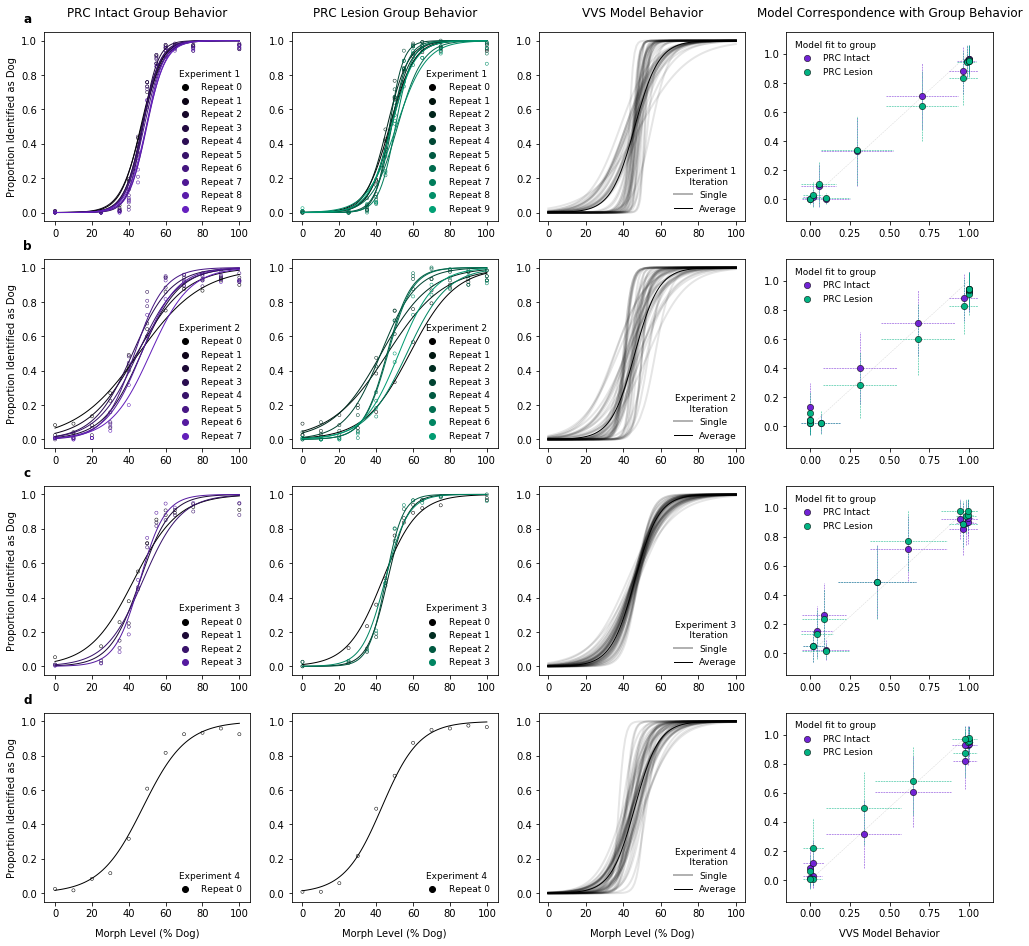

In [28]:
plt.figure(figsize=[17, 16])

show_experimental_performance(df, df_m1)

plt.savefig('./FIGURE1.pdf', bbox_inches = "tight", format='pdf') 

In [115]:
show_model_parameters(smf.ols('choice ~ group',
    data=df.groupby(['group', 'experiment', 'percent'], as_index=False).mean() ),markdown=True) 

$R^{2} = 0.00$ $\beta = 0.01$, $F(1, 86)$ = $0.07, P = 0.941 $

In [116]:
group_behaviors = pandas.DataFrame(
    {'PRC_lesion': df[df.group=='PRC'].groupby(['experiment', 'percent']).mean().choice.values, 
     'PRC_intact': df[df.group=='CON'].groupby(['experiment', 'percent']).mean().choice.values, 
     'model_predictions': df_m1.groupby(['experiment', 'percent']).mean().choice.values})

In [119]:
show_model_parameters( smf.ols('PRC_lesion ~ model_predictions', data=group_behaviors),markdown=True) 

$R^{2} = 0.97$ $\beta = 0.90$, $F(1, 42)$ = $39.95, P = 5 $ x $ 10 ^{-35} $

In [121]:
show_model_parameters( smf.ols('PRC_intact ~ model_predictions', data=group_behaviors),markdown=True) 

$R^{2} = 0.98$ $\beta = 0.89$, $F(1, 42)$ = $46.19, P = 1 $ x $ 10 ^{-37} $

In [128]:
subject_behaviors = df.groupby(['group', 'subject', 'experiment', 'percent'], as_index=False).mean() 

In [137]:
show_model_parameters(smf.ols('subject1 ~ model', data={
    'subject1': subject_behaviors[subject_behaviors.subject==1].choice.values, 
    'model': df_m1.groupby(['experiment', 'percent']).mean().choice.values}), markdown=True) 

$R^{2} = 0.96$ $\beta = 0.89$, $F(1, 42)$ = $33.98, P = 4 $ x $ 10 ^{-32} $

In [138]:
show_model_parameters(smf.ols('subject4 ~ model', data={
    'subject4': subject_behaviors[subject_behaviors.subject==4].choice.values, 
    'model': df_m1.groupby(['experiment', 'percent']).mean().choice.values}), markdown=True) 

$R^{2} = 0.96$ $\beta = 0.92$, $F(1, 42)$ = $32.14, P = 3 $ x $ 10 ^{-31} $

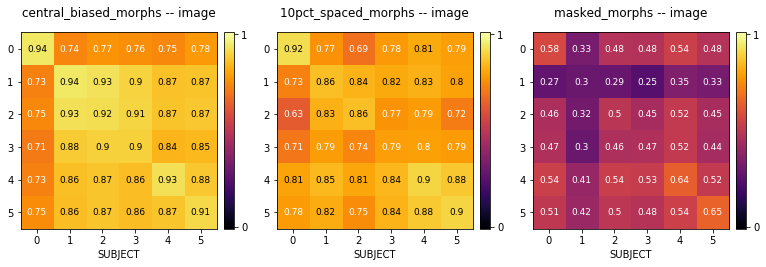

In [139]:
resolution = 'subject'
target = 'image'
measure = 'r2'

image_reliability = get_reliability_matrix(df_reliability, resolution=resolution, target=target,measure=measure)

plt.figure(figsize=[13, 4])
iplot=1

for e in reliability_experiments: 

    ax = plt.subplot(1, 3, iplot); iplot+=1
    mat = image_reliability[e]
    IMSHOW = plt.imshow( mat , clim=[-.01, 1.01], cmap='inferno') 
    show_values(mat, ax)
    plt.title('%s -- %s'%(e, target), y=1.05)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(IMSHOW, cax=cax, ticks=[0, 1]); 

In [145]:
for e in reliability_experiments[0:2]:
    print('\n', e, '\n')
    print('median split-half within subject reliability %.02f'%
          np.median(np.diagonal(image_reliability[e])))
    print('---', np.diagonal(image_reliability[e] ))
    print('median split-half between subject reliability %.02f'%
          np.median([image_reliability[e][i,j] for i in range(6) for j in range(6) if i!=j]))


 central_biased_morphs 

median split-half within subject reliability 0.93
--- [0.94477816 0.94249587 0.92323004 0.89585041 0.92918604 0.91373188]
median split-half between subject reliability 0.86

 10pct_spaced_morphs 

median split-half within subject reliability 0.88
--- [0.92324395 0.86100847 0.86116815 0.79395855 0.90286295 0.90481384]
median split-half between subject reliability 0.79


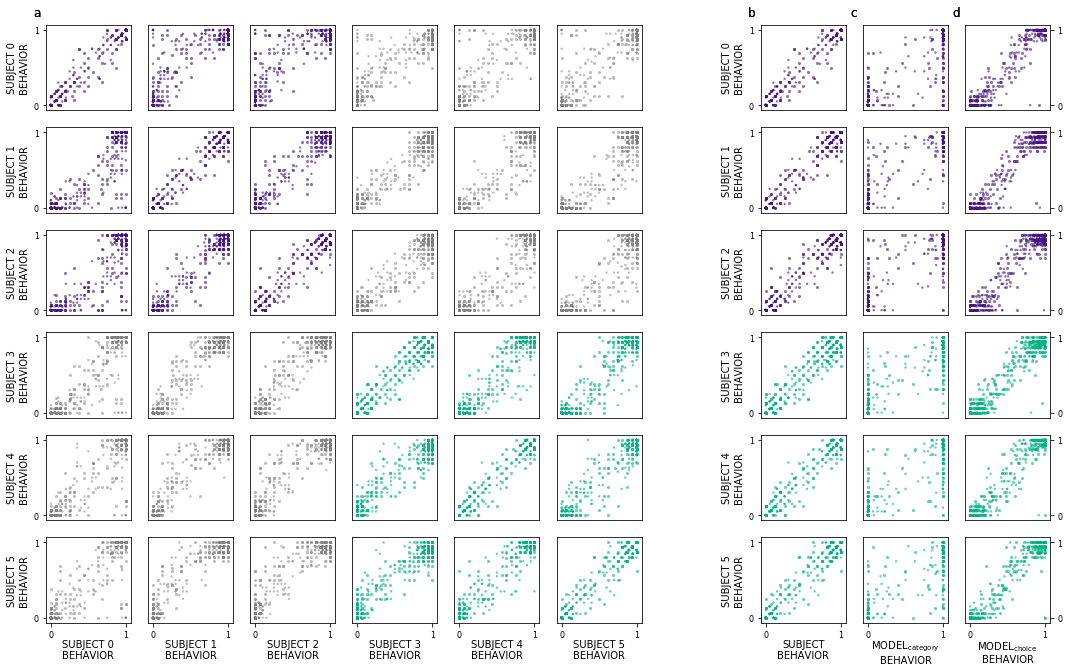

In [29]:
# def model_subject_correspondence(df, df_r, df_m1, df_m2, resolution='subject', target='image'): 

plt.figure(figsize=[18, 11])
def BOUND(vector, MIN=0, MAX=1, SCALE=1): 
    return np.array([max(min(i*SCALE, MAX), MIN) for i in vector])

resolution = 'subject'
target = 'image'
df_r = df_reliability
elements = list( sort(df[resolution].unique()) )
matrix = np.zeros([len(elements), len(elements)])
ncols = len(elements)+4
nrows = len(elements)
pointsize = 6
ticksize  = 8 
labelsize = 10
onalpha   = .6
offalpha  = .5
linewidth = .5
maxp = 101 
minp = -1 

colorscheme = {'central_biased_morphs': {'CON':'#441580',       
                                         'PRC':'#01b282', 
                                         'model':'black'}, 
               '10pct_spaced_morphs': {'CON':'#441580',       
                                       'PRC':'#01b282', 
                                       'model':'grey'}}

for e in ['central_biased_morphs', '10pct_spaced_morphs']: 

    iplot = 1         
    ae = df[(df.experiment==e)]
    aer = df_r[(df_r.experiment==e)]
    m1e = df_m1[(df_m1.experiment==e)]
    m2e = df_m2[(df_m2.experiment==e)]

    for m in elements: 

        x = ae[ae[resolution]==m].groupby(target).mean().choice.values

        for n in elements: 


            if m == n: 
                nits = 2
                maer = aer[aer[resolution]==m]
                x = maer[(maer.split==1)&(maer.iteration<nits)].groupby([target]).mean().choice.values 
                y = maer[(maer.split==2)&(maer.iteration<nits)].groupby([target]).mean().choice.values 
            else: 
                y = ae[ae[resolution]==n].groupby([target]).mean().choice.values 

            ax = plt.subplot(nrows, ncols, iplot)
            plt.xticks([]); 
            plt.yticks([]); 

            if n == elements[0]: 
                plt.ylabel([m, 'SUBJECT %s\nBEHAVIOR'%m][resolution=='subject'], labelpad=5, 
                           fontsize=labelsize)
                plt.yticks([0, 1], [0, 1], fontsize=ticksize)

            if m == elements[-1]: 
                plt.xlabel([n, 'SUBJECT %s\nBEHAVIOR'%n][resolution=='subject'], labelpad=0,
                           fontsize=labelsize)
                plt.xticks([0, 1], [0, 1], fontsize=ticksize)

            if (m==0)&(n==0):  
                plt.text(-.15, 1.1, 'a', fontsize=12, transform=ax.transAxes,)


            alpha=onalpha
            if   (n in [0,1,2])&(m in [0,1,2]): color=colorscheme[e]['CON']
            elif (n in [3,4,5])&(m in [3,4,5]):color=colorscheme[e]['PRC']
            elif (n in [6,7,8])&(m in [6,7,8]): color=colorscheme[e]['TE']
            else: 
                color='grey'
                alpha=offalpha

            x = bound(x, MAX=max(y), SCALE=max(y))

            plt.scatter(x=x, y=y, 
                        alpha=alpha, 
                        s=pointsize,
                        linewidth=[0, linewidth][e=='10pct_spaced_morphs'],
                        facecolor=[color, color][e=='10pct_spaced_morphs'], 
                        edgecolor=['', color][e=='10pct_spaced_morphs']) 


            matrix[m, n] = r2_score(y, x)

            iplot+=1

            
            
        if   (m in [0,1,2]): color=colorscheme[e]['CON']
        elif (m in [3,4,5]): color=colorscheme[e]['PRC']
            
        iplot+=1
        nits = 2
        maer = aer[aer[resolution]==m]
        x_split = maer[(maer.split==1)&(maer.iteration<nits)].groupby([target]).mean().choice.values 
        y_split = maer[(maer.split==2)&(maer.iteration<nits)].groupby([target]).mean().choice.values 
        ax = plt.subplot(nrows, ncols, iplot)
        plt.xticks([]); 
        plt.yticks([]); 
        plt.ylabel([m, 'SUBJECT %s\nBEHAVIOR'%m][resolution=='subject'], labelpad=5, fontsize=labelsize)
        plt.yticks([0, 1], [0, 1], fontsize=ticksize)
        plt.scatter(x=x_split, y=y_split, 
                        alpha=onalpha, 
                        s=pointsize,
                        linewidth=[0, linewidth][e=='10pct_spaced_morphs'],
                        facecolor=[color, color][e=='10pct_spaced_morphs'], 
                        edgecolor=['', color][e=='10pct_spaced_morphs']) 
        if (m==0): 
            plt.text(-.15, 1.1, 'b', fontsize=12, transform=ax.transAxes,)
        if (m==5): 
            plt.xticks([0, 1], [0, 1], fontsize=ticksize)
            plt.xlabel('SUBJECT\nBEHAVIOR',  labelpad=0, fontsize=labelsize)
        
        iplot+=1
        
        #
        y_target = ae[ae[resolution]==m].groupby(target).mean().choice.values
        
        # MODEL 0 
        ax = plt.subplot(nrows, ncols, iplot) #ax.set_facecolor(color) #(1.0, 0.47, 0.42))
        x_model = m1e.groupby([target]).mean().choice.values
        plt.scatter(x=x_model, y=y_target, 
                    alpha=onalpha, 
                    s=pointsize, 
                    linewidth=[0, linewidth][e=='10pct_spaced_morphs'],
                    facecolor=[color, color][e=='10pct_spaced_morphs'], 
                    edgecolor=['', color][e=='10pct_spaced_morphs'])
        
        plt.xticks([]); 
        plt.yticks([]);         
        if m == elements[-1]: 
            plt.xticks([0, 1], [0, 1], fontsize=ticksize)
            plt.xlabel('MODEL$_{\mathrm{category}}$\nBEHAVIOR', labelpad=0, fontsize=labelsize)
        if (m==0): 
            plt.text(-.15, 1.1, 'c', fontsize=12, transform=ax.transAxes,)
        #plt.legend([], [], title='$R^{2}$=%.02f'%r2_score(x, x_model), loc=2, framealpha=0, fontsize=8)
        iplot+=1

        # MODEL 2
        ax = plt.subplot(nrows, ncols, iplot)
        x_model = BOUND(m2e[m2e[resolution]==m].groupby([target]).mean().choice.values)
        plt.scatter(x=x_model, y=y_target, 
                alpha=onalpha,
                s=pointsize,
                linewidth=[0, linewidth][e=='10pct_spaced_morphs'], 
                facecolor=[color, color][e=='10pct_spaced_morphs'], 
                edgecolor=['', color][e=='10pct_spaced_morphs'])
        
        plt.xticks([]); 
        plt.yticks([]); 
        ax.yaxis.set_label_position("right")
        ax.yaxis.tick_right()
        plt.yticks([0, 1], [0, 1], fontsize=ticksize)
        if m == elements[-1]: 
            plt.xticks([0, 1], [0, 1], fontsize=ticksize)
            plt.xlabel('MODEL$_{\mathrm{choice}}$\nBEHAVIOR', labelpad=0, fontsize=labelsize)
        if (m==0): 
            plt.text(-.15, 1.1, 'd', fontsize=12, transform=ax.transAxes)
        #plt.legend([], [], title='$R^{2}$=%.02f'%r2_score(x, x_model), loc=2, framealpha=0, fontsize=8)        
        iplot+=1

plt.savefig('./FIGURE2.pdf', bbox_inches = "tight", format='pdf')

In [42]:
from scipy.stats import ranksums
from scipy import stats 

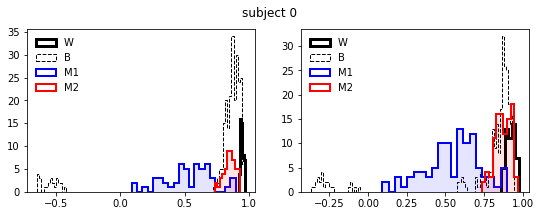

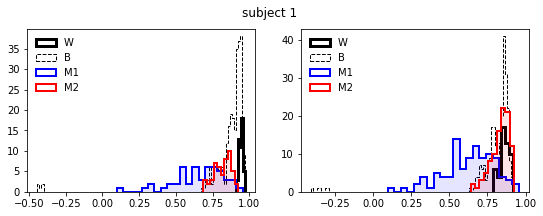

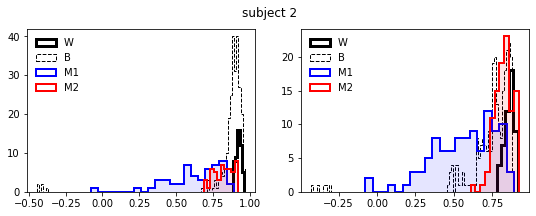

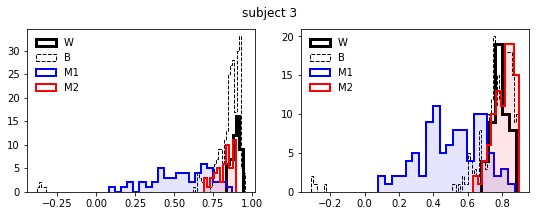

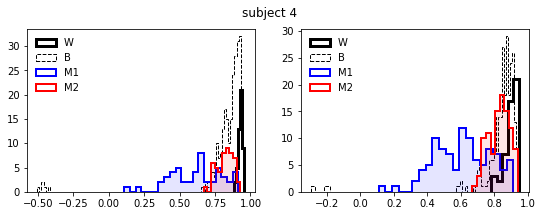

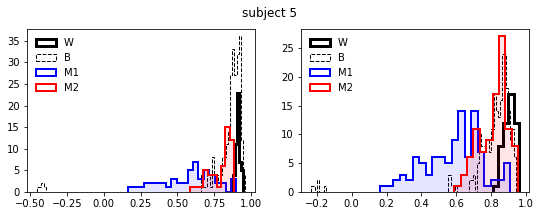

In [44]:
df_distributions = pandas.DataFrame()

for s in range(6): 

    model1_fits = [] 
    model2_fits = []        
    
    iplot=1
    plt.figure(figsize=[9,3])   
    for e in ['central_biased_morphs', '10pct_spaced_morphs']: 
        
        res = df_reliability[(df_reliability.subject==s)&(df_reliability.experiment==e)]
        m1 = df_m1[df_m1.experiment==e]
        m2 = df_m2[(df_m2.experiment==e)&(df_m2.subject==s)]

        for i in df_m1.iteration.unique():

            i_r = res[(res.iteration==i)&(res.subject==s)]    

            # MODEL ONE
            i_df1 = m1[(m1.iteration==i)]        
            i_rm1 = i_r[[i in i_df1.image.values for i in i_r.image.values]]     
            model1_fits.append( r2_score(i_rm1[i_rm1.split==1].choice.values, i_df1.choice.values) ) 

            # MODEL TWO 
            i_df2 = m2[(m2.iteration==i)&(m2.subject==s)]
            i_rm2 = i_r[[i in i_df2.image.values for i in i_r.image.values]]     
            model2_fits.append(r2_score(i_rm2[i_rm2.split==1].choice.values, i_df2.choice.values) ) 

        
        
        _within = np.array(image_reliability['noise'][e][s, s])
        _between = np.array([image_reliability['noise'][e][s, i] for i in range(6) if i != s]).flatten() 
        
        _df = pandas.DataFrame({
          'experiment': [e], 
          'subject': [s], 
          'P(w|M1)': [np.mean( np.array(model1_fits) >=  np.median(_within))], 
          'P(b|M1)': [np.mean( np.array(model1_fits) >=  np.median(_between))], 
          'P(M1|w)': [np.mean( np.array(_within) <=  np.median(model1_fits))], 
          'P(M1|b)': [np.mean( np.array(_between) <=  np.median(model1_fits))], 
          'P(w|M2)': [np.mean( np.array(model2_fits) >=  np.median(_within))], 
          'P(b|M2)': [np.mean( np.array(model2_fits) >=  np.median(_between))], 
          'P(M2|w)': [np.mean( np.array(_within) <=  np.median(model2_fits))], 
          'P(M2|b)': [np.mean( np.array(_between) <=  np.median(model2_fits))], 
          'wilcoxon_M1_M2':[ranksums(model1_fits, model2_fits).pvalue]
                         }, )
        
        df_distributions = df_distributions.append(_df, ignore_index=True)
        
        plt.subplot(1,2,iplot)
        plt.hist( _within, bins=5, alpha=1, color='black', label='W', linestyle='-',histtype='step', linewidth=3)
        plt.hist( _between, bins=100, alpha=1,  color='black', linestyle='--', label='B', histtype='step')
        
        plt.hist( model1_fits, bins=20, alpha=1, color='blue', label='M1', histtype='step', linewidth=2)
        plt.hist( model1_fits, bins=20, alpha=.1, color='blue')
        plt.hist( model2_fits, bins=10, alpha=1, color='red', label='M2', histtype='step', linewidth=2)
        plt.hist( model2_fits, bins=10, alpha=.1, color='red')
        plt.legend(loc=2, framealpha=0)        
        iplot+=1
    plt.suptitle('subject %d'%s)
    plt.show()

In [45]:
df_distributions

,experiment,subject,P(w|M1),P(b|M1),P(M1|w),P(M1|b),P(w|M2),P(b|M2),P(M2|w),P(M2|b),wilcoxon_M1_M2
0,central_biased_morphs,0,0.00,0.02,0.0,0.100,0.00,0.38,0.00,0.380,1.035122e-14
1,10pct_spaced_morphs,0,0.00,0.02,0.0,0.108,0.22,0.54,0.02,0.536,1.882461e-30
2,central_biased_morphs,1,0.02,0.04,0.0,0.024,0.00,0.04,0.00,0.196,2.864468e-08
3,10pct_spaced_morphs,1,0.06,0.07,0.0,0.024,0.40,0.53,0.36,0.560,8.577229e-22
4,central_biased_morphs,2,0.00,0.00,0.0,0.020,0.00,0.18,0.00,0.108,1.364031e-09
5,10pct_spaced_morphs,2,0.03,0.19,0.0,0.100,0.25,0.76,0.16,0.664,9.462766e-23
6,central_biased_morphs,3,0.00,0.02,0.0,0.020,0.00,0.22,0.02,0.284,5.384349e-15
7,10pct_spaced_morphs,3,0.04,0.04,0.0,0.024,0.71,0.69,0.74,0.664,1.817553e-29
8,central_biased_morphs,4,0.00,0.08,0.0,0.020,0.00,0.18,0.00,0.312,2.371838e-09
9,10pct_spaced_morphs,4,0.01,0.06,0.0,0.036,0.08,0.30,0.10,0.348,2.035841e-20
